# Seizure detection sandbox

## Workspace Preparation

In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')


In [2]:
plt.rcParams['image.cmap'] = 'magma'

In [3]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
figpath = CONFIG["paths"]["FIGURES"]
patient_table = pd.DataFrame(CONFIG["patients"]).sort_values('ptID')
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = patient_table.ptID.to_numpy()

In [4]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
set_seed(5210)

In [5]:
set_seed(5210)

In [6]:
pt = 'HUP235'
montage = 'bipolar'

## Defining Model Architectures

## Pulling Ictal Data

In [7]:
 # Defining paths for saved data
raw_datapath = ospj(datapath,pt)
if not os.path.exists(ospj(raw_datapath, "seizures")):
    os.mkdir(ospj(raw_datapath, "seizures"))

In [8]:
seizure_times = pd.read_csv('../HUP235_seizure_times.csv')

In [9]:
# access iEEG
with open('woj_ieeglogin.bin', 'r') as f:
  session = Session('wojemann', f.read())
ds = session.open_dataset('HUP235_phaseII')
# if re.search('Cz|Fz|C3|C4|EKG',i)
# get labels and time series info
raw_labels = clean_labels(ds.get_channel_labels(),'HUP235')
chn_labels = [l for l in raw_labels if l not in ['Cz','Fz','C03','C04','EKG01','EKG02','ROC','LOC']]

timeseries = ds.get_time_series_details('LC01')

#get the sampling frequency
fs = timeseries.sample_rate

### Code for saving and preprocessing

In [ ]:
def preprocess_presave(data,fs,montage='bipolar',factor=4):
    chs = data.columns.to_list()
    ch_df = check_channel_types(chs)
    # Montage
    if montage == 'bipolar':
        data_bp_np,bp_ch_df = bipolar_montage(data.to_numpy().T,ch_df)
        bp_ch = bp_ch_df.name.to_numpy()
    elif montage == 'car':
        data_bp_np = (data.to_numpy().T - np.mean(data.to_numpy(),1))
        bp_ch = chn_labels
    # Bandpass filtering
    b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
    data_bp_filt = sc.signal.filtfilt(b,a,data_bp_np,axis=1)
    # Down sampling
    data_bpd = sc.signal.decimate(data_bp_filt,4).T
    fsd = fs/4
    data_bpd_df = pd.DataFrame(data_bpd,columns = bp_ch)
    return data_bpd_df,fsd

In [10]:
# # # Iterate through each seizure and run Andy's preprocessing and save it
# for i_sz,row in seizure_times.iterrows():
#     if i_sz not in [0,5,9]:
#         continue
#     print(f"Saving seizure number: {i_sz}")
#     seizure,fs = get_iEEG_data(usr,'woj_ieeglogin.bin',
#                                 row.iEEG_ID,
#                                 (row.Onset-60)*1e6,
#                                 (row.Offset+60)*1e6,
#                                 chn_labels,
#                                 force_pull = True)
#     chs = seizure.columns.to_list()
#     ch_df = check_channel_types(chs)
#     plot_iEEG_data(seizure,np.arange(len(seizure))/fs)
#     # Bipolar montage
#     if montage == 'bipolar':
#         seizure_bp_np,bp_ch_df = bipolar_montage(seizure.to_numpy().T,ch_df)
#         bp_ch = bp_ch_df.name.to_numpy()
#     elif montage == 'car':
#         seizure_bp_np = (seizure.to_numpy().T - np.mean(seizure.to_numpy(),1))
#         bp_ch = chn_labels
#     plot_iEEG_data(pd.DataFrame(seizure_bp_np.T,columns=bp_ch),np.arange(len(seizure))/fs)
#     # Bandpass filtering
#     b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
#     seizure_bp_filt = sc.signal.filtfilt(b,a,seizure_bp_np,axis=1)
#     # Down sampling
#     factor = 4
#     seizure_bpd = sc.signal.decimate(seizure_bp_filt,4).T
#     fsd = fs/4
#     seizure_bpd_df = pd.DataFrame(seizure_bpd,columns = bp_ch)
#     plot_iEEG_data(pd.DataFrame(seizure_bpd,columns=bp_ch),np.arange(len(seizure_bpd))/fsd)
#     seizure_bpd_df.to_pickle(ospj(raw_datapath,"seizures",f"det256_seizure_{i_sz}_stim_{0}_{montage}.pkl"))

## Training Unsupervised Models

* identify a good 10 second window for training
    * 307651
* preprocess: montage, bandpass [3,58], decimate by 4
* save it
* train model
    * 1 second windows, .5 second overlap

### Code for saving and preprocessing

In [11]:
# print(f"Saving interictal training data")
# INTERTIME = 307651
# pt_ieeg = 'HUP235_phaseII'
# inter,fs = get_iEEG_data(usr,'woj_ieeglogin.bin',
#                             pt_ieeg,
#                             INTERTIME*1e6,
#                             (INTERTIME+10)*1e6,
#                             chn_labels,
#                             force_pull = True)
# chs = inter.columns.to_list()
# ch_df = check_channel_types(chs)
# # plot_iEEG_data(inter,np.arange(len(inter))/fs)
# # Bipolar montage
# if montage == 'bipolar':
#     inter_bp_np,bp_ch_df = bipolar_montage(inter.to_numpy().T,ch_df)
#     bp_ch = bp_ch_df.name.to_numpy()
# elif montage == 'car':
#     inter_bp_np = (inter.to_numpy().T - np.mean(inter.to_numpy(),1))
#     bp_ch = chn_labels
# plot_iEEG_data(pd.DataFrame(inter_bp_np.T,columns=bp_ch),np.arange(len(inter))/fs)
# # Bandpass filtering
# b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
# inter_bp_filt = sc.signal.filtfilt(b,a,inter_bp_np,axis=1)
# # Down sampling
# factor = 4
# inter_bpd = sc.signal.decimate(inter_bp_filt,4).T
# fsd = fs/4
# inter_bpd_df = pd.DataFrame(inter_bpd,columns = bp_ch)
# plot_iEEG_data(pd.DataFrame(inter_bpd,columns=bp_ch),np.arange(len(inter_bpd))/fsd)
# inter_bpd_df.to_pickle(ospj(raw_datapath,"seizures",f"det256_interictal_{montage}.pkl"))

### Code for data formatting and training

#### data formatting

In [12]:
def NumWins(x,fs,winLen,winDisp): 
   return int(np.floor(1 + (len(x)/fs - winLen)/winDisp))

def MovingWinClips(x,fs,winLen,winDisp):
  # calculate number of windows and initialize receiver
  nWins = NumWins(x,fs,winLen,winDisp)
  samples = np.empty((nWins,winLen*fs))
  # create window indices - these windows are left aligned
  idxs = np.array([(winDisp*fs*i,(winLen+winDisp*i)*fs)\
                   for i in range(nWins)],dtype=int)
  # apply feature function to each channel
  for i in range(idxs.shape[0]):
    samples[i,:] = x[idxs[i,0]:idxs[i,1]]
  
  return samples



In [13]:
def prepare_segment(data, fs = 256,train_win = 12, pred_win = 1, w_size = 1, w_stride=0.5,ret_time=False):
    data_ch = data.columns.to_list()
    data_np = data.to_numpy()
    train_win = 12
    pred_win = 1
    j = fs-(train_win+pred_win)+1
    nwins = NumWins(data_np[:,0],fs,w_size,w_stride)
    data_mat = torch.zeros((nwins,j,(train_win+pred_win),len(data_ch)))
    for k in range(len(data_ch)): # Iterating through channels
        samples = MovingWinClips(data_np[:,k],fs,1,0.5)
        for i in range(samples.shape[0]):
            clip = samples[i,:]
            mat = torch.tensor(hankel(clip[:j],clip[-(train_win+pred_win):]))
            data_mat[i,:,:,k] = mat
    time_mat = MovingWinClips(np.arange(len(data))/fs,fs,1,0.5)
    win_times = time_mat[:,0]
    data_flat = data_mat.reshape((-1,train_win + pred_win,len(data_ch)))
    input_data = data_flat[:,:-1,:].float()
    target_data = data_flat[:,-1,:].float()
    if ret_time:
        return input_data, target_data, win_times
    else:
        return input_data, target_data

In [14]:
def predict_sz(model, input_data, target_data,batch_size=1):
    dataset = TensorDataset(input_data,target_data)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
    ccheck = torch.cuda.is_available()
    if ccheck:
        model.cuda()
    with torch.no_grad():
        model.eval()
        mse_distribution = []
        for inputs, targets in tqdm(dataloader):
            if ccheck:
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            mse = (outputs-targets)**2
            mse_distribution.append(mse)
    return torch.cat(mse_distribution).cpu().numpy()

In [15]:
def repair_data(outputs,data,fs=256,train_win=12,pred_win=1,w_size=1,w_stride=.5):
    nwins = NumWins(data.to_numpy()[:,0],fs,w_size,w_stride)
    nchannels = data.shape[1]
    repaired = outputs.reshape((nwins,fs-(train_win + pred_win)+1,nchannels))
    return repaired

#### preparing training

In [16]:
inter = pd.read_pickle(ospj(raw_datapath,"seizures",f"det256_interictal_{montage}.pkl"))
fs = 256

In [17]:
# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter)

dataset = TensorDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# Instantiate the model
input_size = input_data.shape[2]
hidden_size = 10
output_size = input_data.shape[2]

In [18]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1,:])
        return out
    
class LRModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Flatten the input along the 'sequence length' dimension
        x = x.squeeze()
        out = self.linear(x)
        return out


#### model initialization and training

In [19]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, output_size)
print(model)
ccheck = torch.cuda.is_available()
if ccheck:
   model.cuda()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

LSTMModel(
  (lstm): LSTM(85, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=85, bias=True)
)


In [20]:
# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        if ccheck:
            inputs = inputs.cuda()
            targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 9:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 378.7021
Epoch [20/300], Loss: 370.0432
Epoch [30/300], Loss: 361.4050
Epoch [40/300], Loss: 348.4897
Epoch [50/300], Loss: 339.6675
Epoch [60/300], Loss: 331.1038
Epoch [70/300], Loss: 322.2411
Epoch [80/300], Loss: 313.9903
Epoch [90/300], Loss: 307.7825
Epoch [100/300], Loss: 300.7131
Epoch [110/300], Loss: 292.6638
Epoch [120/300], Loss: 282.6991
Epoch [130/300], Loss: 276.9725
Epoch [140/300], Loss: 273.2268
Epoch [150/300], Loss: 268.8616
Epoch [160/300], Loss: 265.1729
Epoch [170/300], Loss: 261.0777
Epoch [180/300], Loss: 256.9603
Epoch [190/300], Loss: 252.4394
Epoch [200/300], Loss: 248.2313
Epoch [210/300], Loss: 243.7754
Epoch [220/300], Loss: 240.5734
Epoch [230/300], Loss: 237.2201
Epoch [240/300], Loss: 234.0534
Epoch [250/300], Loss: 231.9510
Epoch [260/300], Loss: 228.9225
Epoch [270/300], Loss: 225.1619
Epoch [280/300], Loss: 223.2764
Epoch [290/300], Loss: 219.9837
Epoch [300/300], Loss: 216.9220


#### determining detection threshold

In [21]:
input_data,target_data = prepare_segment(inter)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=400)
thresholds = np.percentile(inter_outputs,95,0)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 315.42it/s]


## Seizure Detection

### Generating probability heatmaps

In [22]:
seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"det256_seizure_{9}_stim_{0}_{montage}.pkl"))

In [23]:
train_win = 12
pred_win = 1
input_data, target_data, win_times = prepare_segment(seizure,fs,train_win,pred_win,ret_time=True)

In [24]:
outputs = predict_sz(model,input_data,target_data,400)
seizure_mat = repair_data(outputs,seizure)

100%|██████████| 307/307 [00:01<00:00, 298.24it/s]


In [31]:
sz_clf = (np.mean(np.log(seizure_mat),1) > np.log(thresholds)).T
sz_vals = sc.ndimage.uniform_filter1d(np.mean(np.log(seizure_mat),1).T,20,axis=1)
sz_prob = sc.ndimage.uniform_filter1d(sz_clf.astype(float),20,axis=1)
first_detect = np.argmax(sz_prob[:,120:]>.6,axis=1)
first_detect[first_detect == 0] = sz_prob.shape[1]
ch_sorting = np.argsort(first_detect)

### Plotting seizure detection pipeline

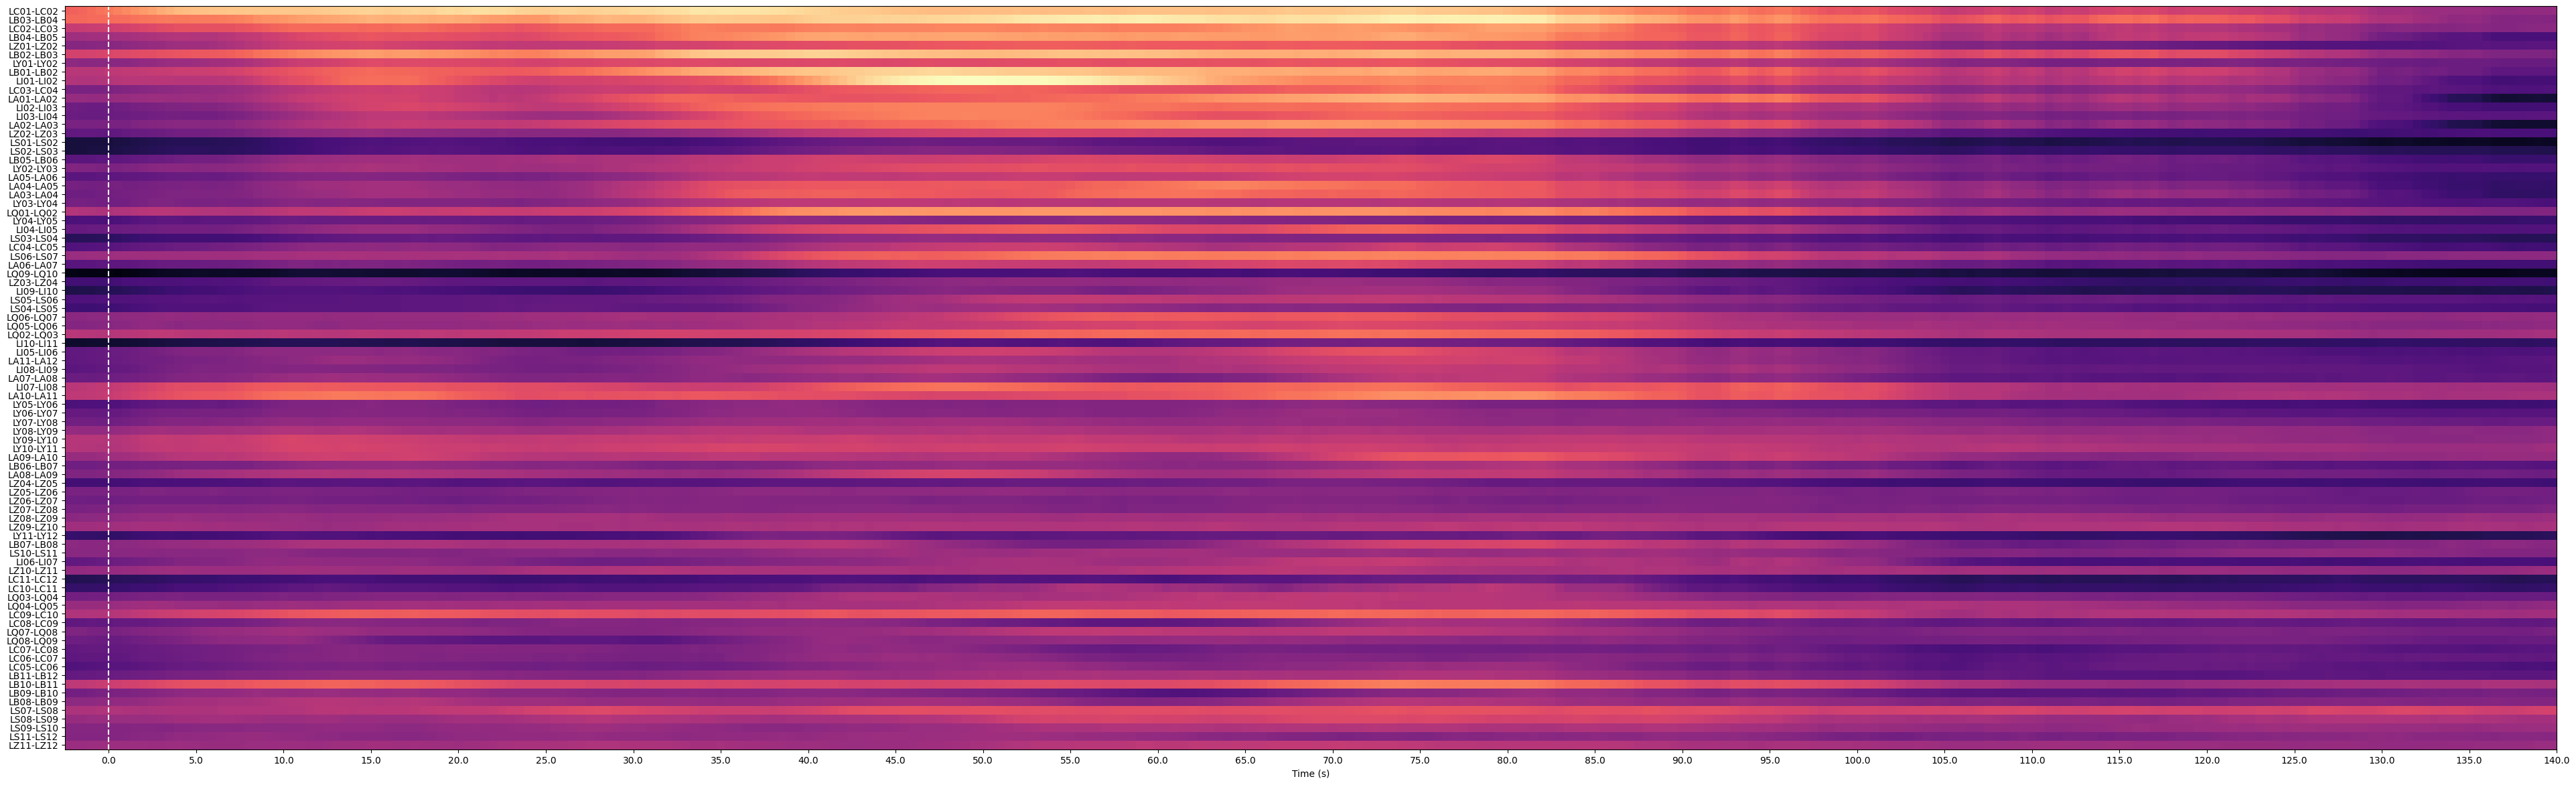

In [32]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_vals[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_vals.png'))

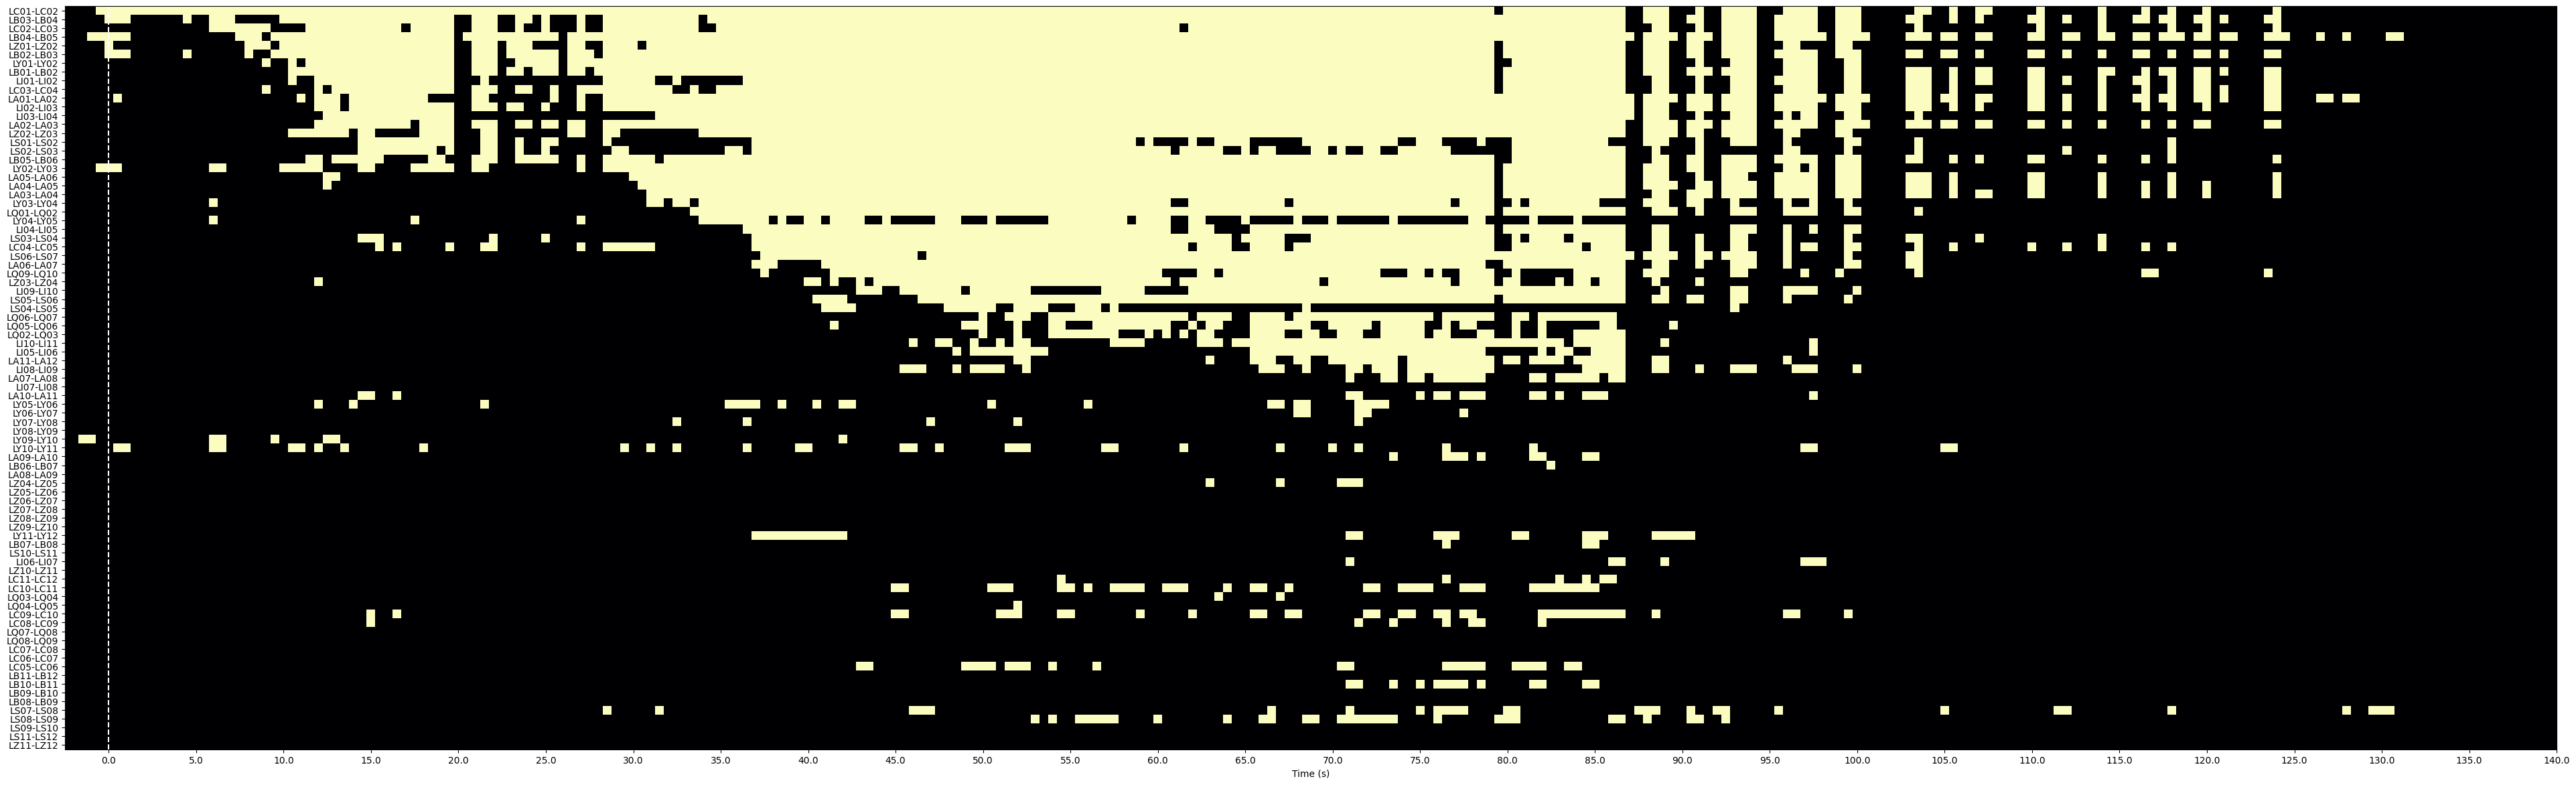

In [33]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_clf[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_vals.png'))

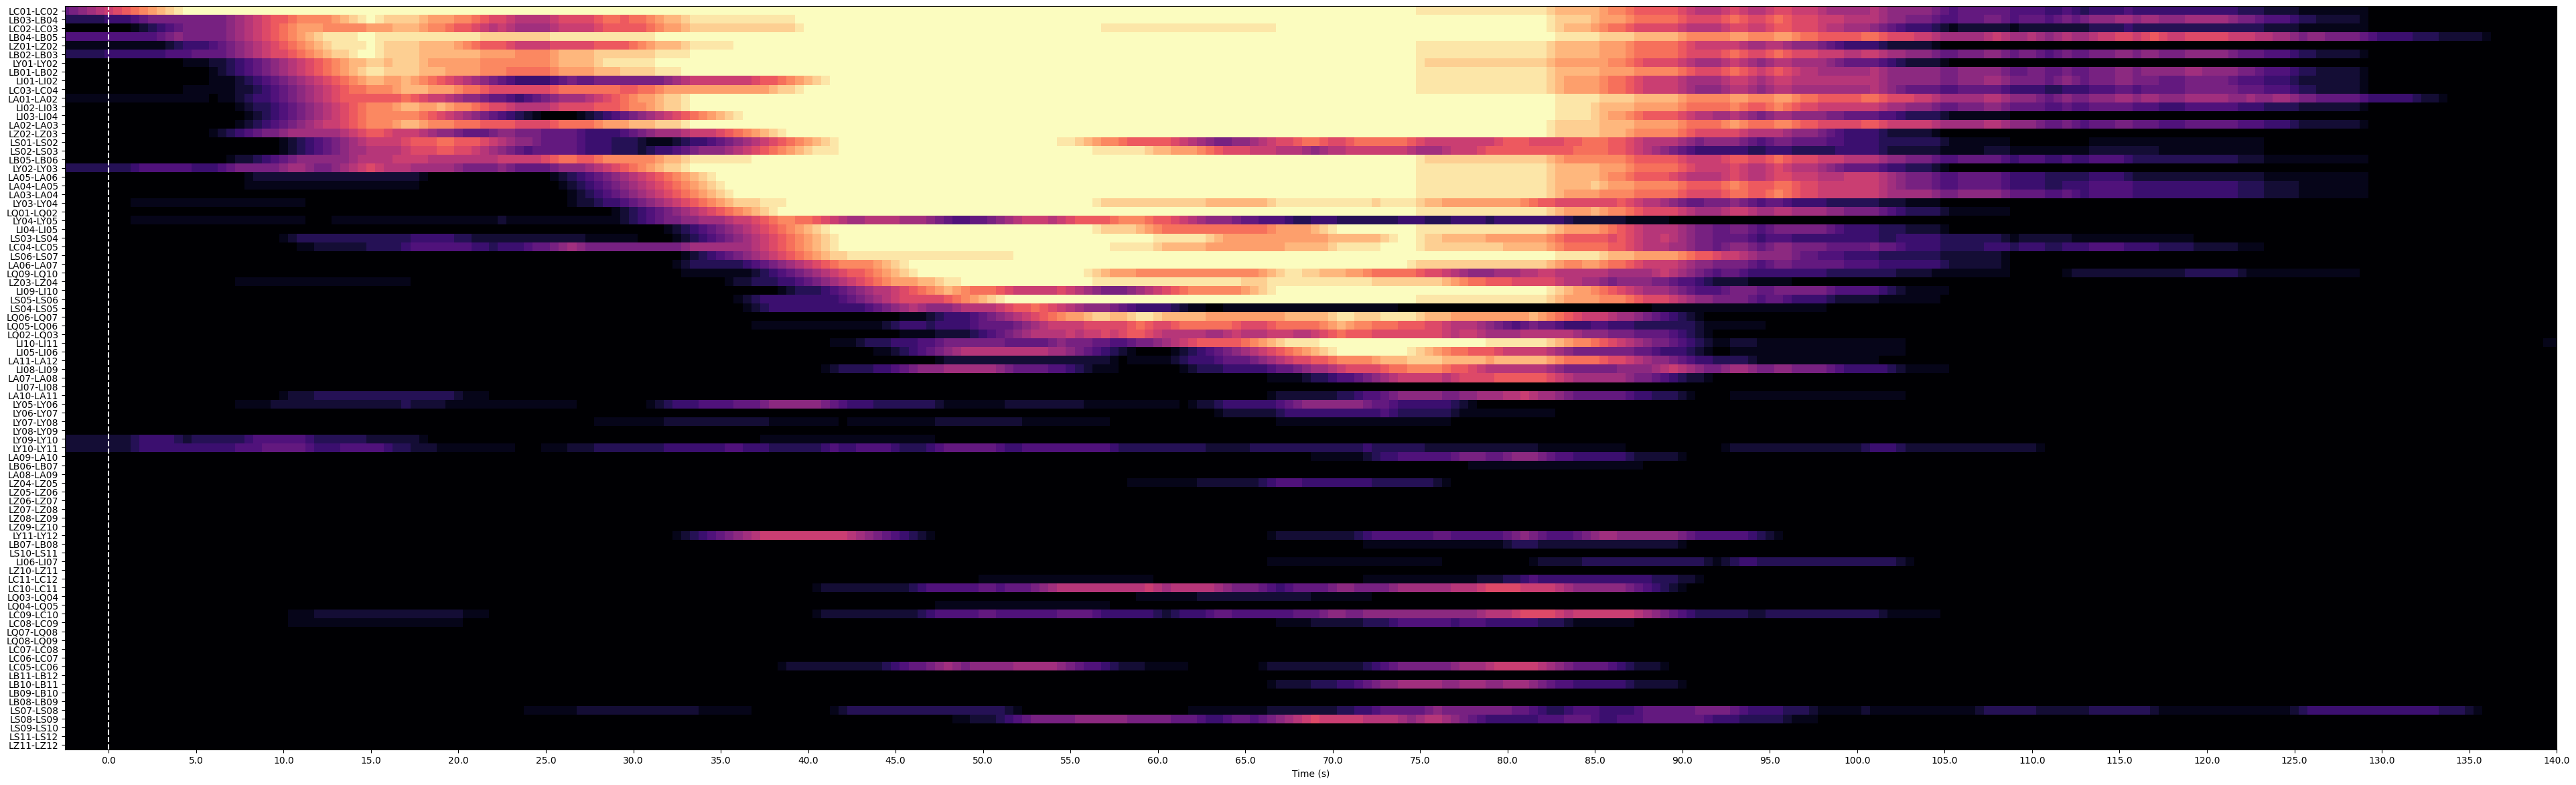

In [29]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_prob.png'))

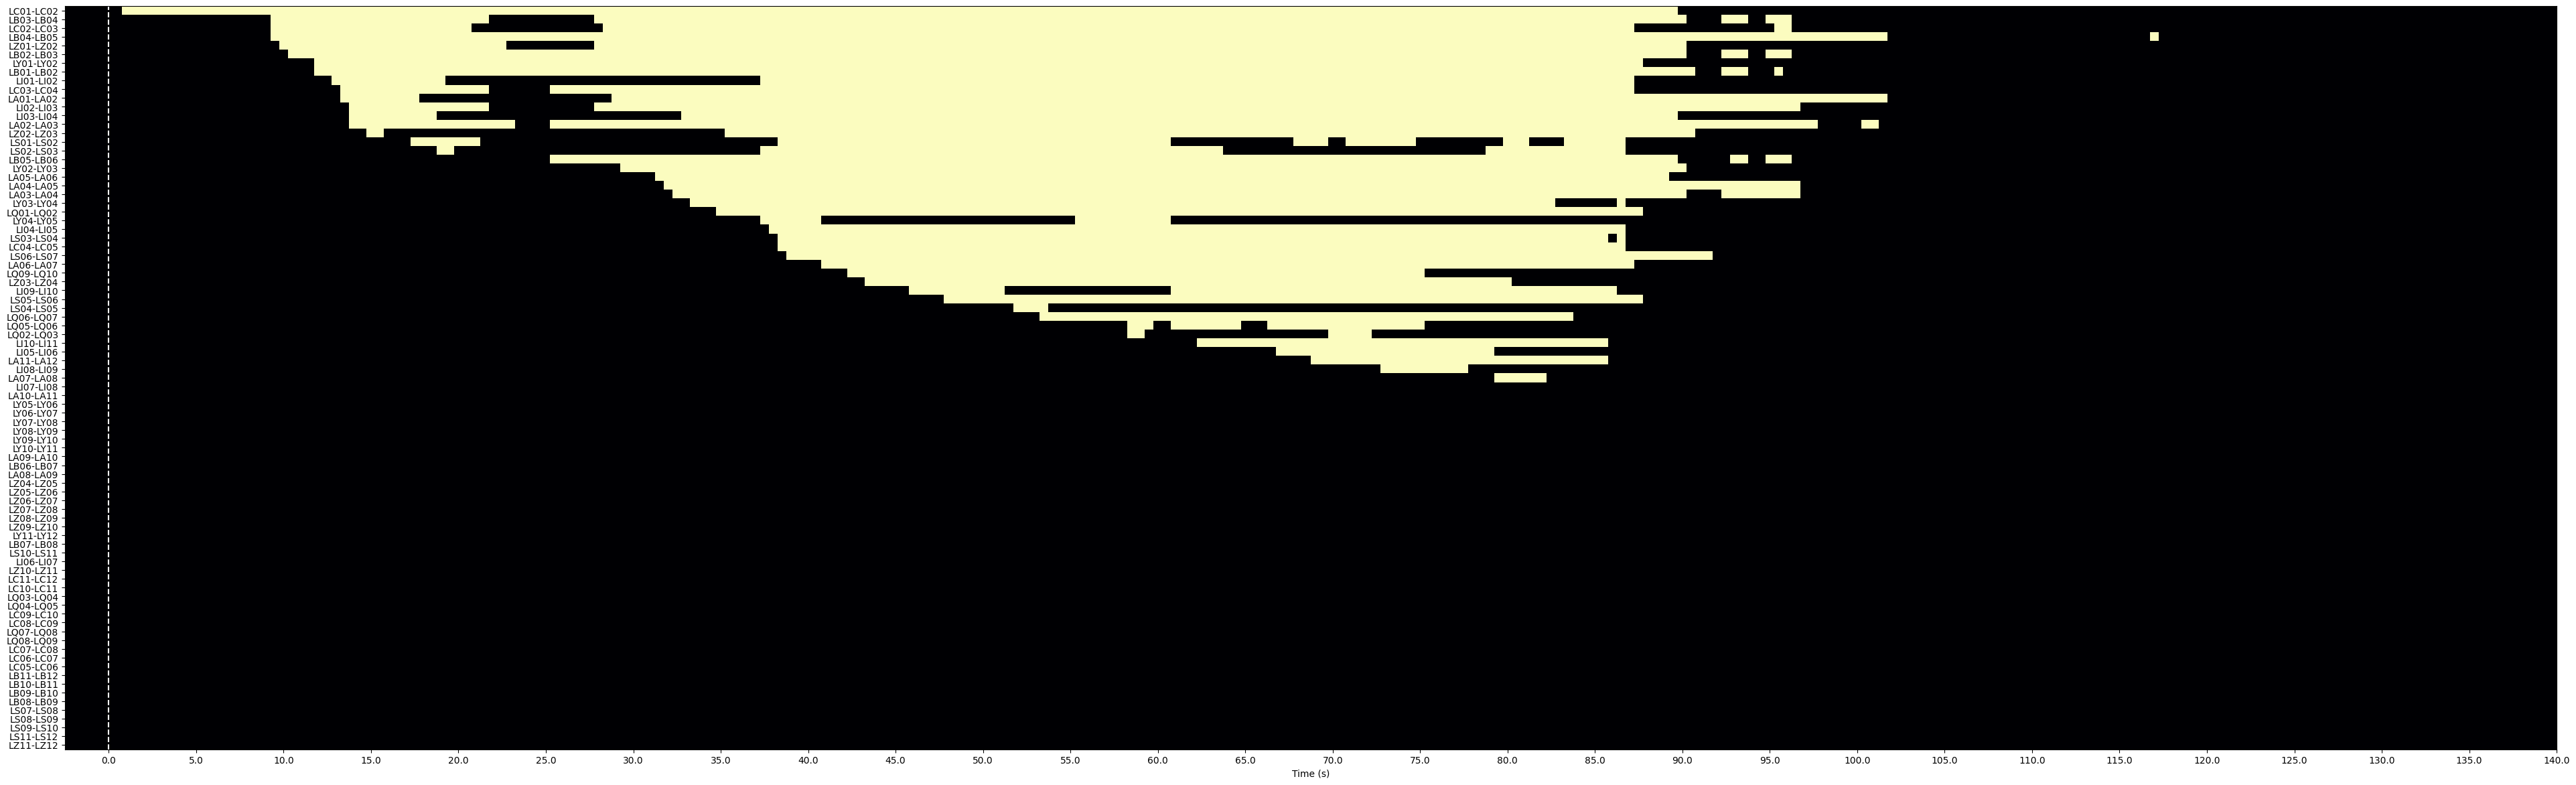

In [28]:
# Example threshold set to 0.6. Will find optimal threshold when we have 
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:]>.6)
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_classification.png'))

### LineLength Null